# Imports

In [1]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score
from sklearn.utils import column_or_1d
from sklearn import linear_model
from scipy.optimize import linprog
import scipy as sc
from scipy.linalg import block_diag
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as plt
from tqdm import tqdm_notebook as tqdm #timing

In [2]:
# Constants
EARNINGS_STEP = 5000
AGE_STEP = 5
EDUC_STEP = 3

# Question 1

In [3]:
# Read the CSV and put 0.0 values to NaN
lalonde_df = pd.read_csv('lalonde.csv', na_values={'re78': 0.0})

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [5]:
def plot_distribution(df, attr, step):
    # Remove NaN values and add a category column
    attr_df = df.dropna(subset=[attr]).copy()
    attr_df['category'] = attr_df[attr] // step

    # Compute the labels
    categories = np.sort(attr_df['category'].unique()) * step
    labels = []
    for i in range(len(categories)):
        current = categories[i]
        if i == len(categories) - 1:
            nextt = '+'
        else:
            nextt = str(int(categories[i+1]))

        labels.append('[%d, %s]' % (current, nextt))

    # Show with a barplot the average (again) with the uncertainty
    g = sb.countplot(y='category', hue='treat', data=attr_df)
    g.set(yticklabels=labels)
    
def plot_distribution_binary(df, attr):
    # Remove NaN values and add a category column
    attr_df = df.dropna(subset=[attr]).copy()

    # Show with a barplot the average (again) with the uncertainty
    g = sb.countplot(y=attr, hue='treat', data=attr_df)

In [9]:
# Compute the mean in earnings (1978) for both treatments
print("Mean of earnings (full dataset):")
print("Control group:", np.mean(lalonde_df[lalonde_df['treat'] == 0]['re78']))
print("Treated group:", np.mean(lalonde_df[lalonde_df['treat'] == 1]['re78']))

Mean of earnings (full dataset):
Control group: 9051.990391087618
Treated group: 8389.939665


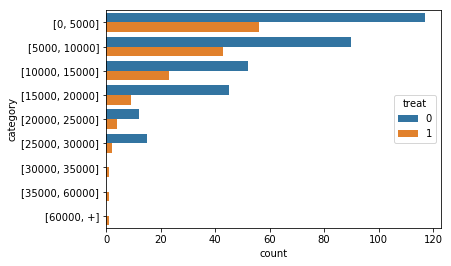

In [6]:
# Show the distribution of earnings
plot_distribution(lalonde_df, 're78', EARNINGS_STEP)

#### Result
A naive "researcher" would say that the control group people earn more in average, thus the treatment didn't do anything (and it would even be better not to do it).

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

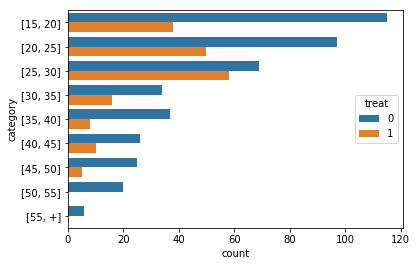

In [7]:
plot_distribution(lalonde_df, 'age', AGE_STEP)

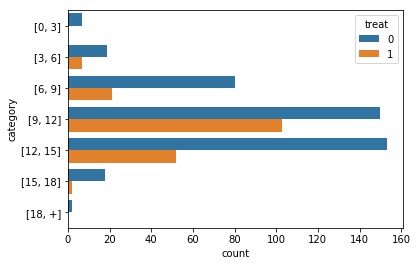

In [8]:
plot_distribution(lalonde_df, 'educ', EDUC_STEP)

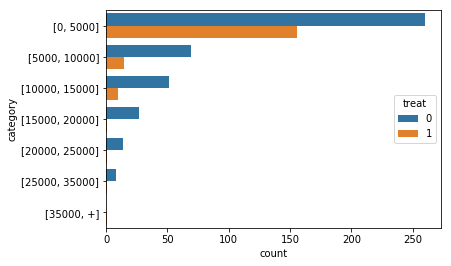

In [9]:
plot_distribution(lalonde_df, 're74', EARNINGS_STEP)

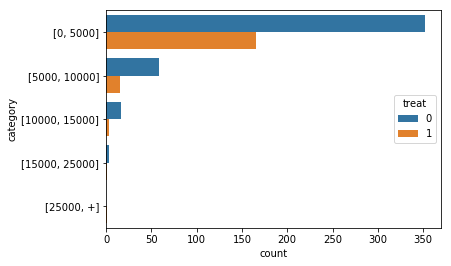

In [10]:
plot_distribution(lalonde_df, 're75', EARNINGS_STEP)

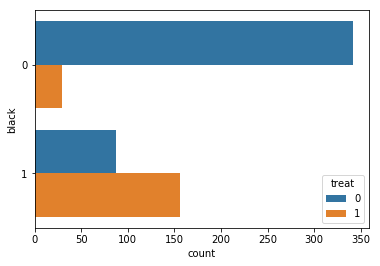

In [11]:
plot_distribution_binary(lalonde_df, 'black')

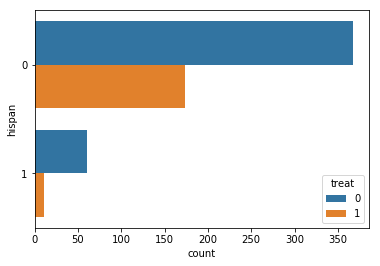

In [12]:
plot_distribution_binary(lalonde_df, 'hispan')

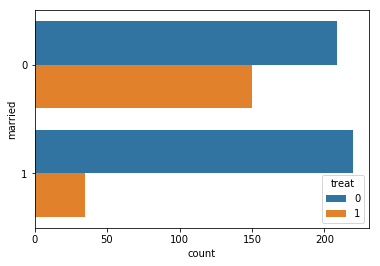

In [13]:
plot_distribution_binary(lalonde_df, 'married')

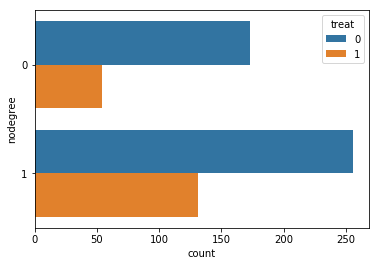

In [14]:
plot_distribution_binary(lalonde_df, 'nodegree')

#### Result
The dataset is unbalanced because we can see that the people in the control group and in the treated group are not similar, we can see that the distributions are quite different (e.g. lots of "non-black people" in the control group compared to the treated group). This means that the conclusion made by the "naive" researcher are wrong because it is not based on a balanced dataset.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [11]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Compute 'w' in order to get the propensity scores
logistic = linear_model.LogisticRegression()
X = lalonde_df.drop(['id', 'treat', 're78'], axis=1)
y = lalonde_df['treat']
logistic.fit(X, y)
w = logistic.coef_

# Standardize score and compute probability (propensity score) using sigmoid
score = X.dot(w.T)
score = (score - np.mean(score)) / np.std(score)
prob = sigmoid(score)

# DataFrame with propensity score
propensity_df = lalonde_df.copy()
propensity_df['prop_score'] = prob
propensity_df.treat.value_counts()

propensity_df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_score
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.655065
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.423209
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.797036
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.768438
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.785170


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?



In [85]:
def construct_constraints(df):
    for i in tqdm(range(1)):
        non_t_size, t_size = df.treat.value_counts().values

        score1 = clean_df.loc[clean_df['treat'] == 1, 'prop_score'].as_matrix()
        score0 = clean_df.loc[clean_df['treat'] == 0, 'prop_score'].as_matrix()
        c_ = np.abs( score1 - score0[:,None])
        b = np.concatenate((-1*np.ones(t_size), np.ones(non_t_size)))
        A1 = block_diag(*(-1*np.ones((t_size,non_t_size))))
        A2 = np.tile(np.identity(non_t_size),t_size)
        A = np.vstack([A1,A2])
    return np.ravel(c_.T), A, b

In [79]:

print(np.array(A).shape)

def solve_linprog(c,A,b):
    bounds = [(0, None)] * len(c)
    for t in tqdm(range(1)):
        res = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='interior-point')
    return res

(471, 46340)


In [86]:
c, A, b = construct_constraints(clean_df)

In [87]:

res = solve_linprog(c,A,b)

In [88]:
res

     con: array([], dtype=float64)
     fun: 16.596895503301308
 message: 'Optimization terminated successfully.'
     nit: 20
   slack: array([  4.22267776e-10,   4.83620699e-10,   4.22009316e-10,
         4.22036628e-10,   4.22014423e-10,   4.22015312e-10,
         4.22043067e-10,   4.22026858e-10,   1.08618048e-09,
         4.22004653e-10,   4.22007096e-10,   4.22216040e-10,
         4.22008650e-10,   4.22008206e-10,   4.22052171e-10,
         4.22037960e-10,   4.22013091e-10,   4.21987334e-10,
         6.09452711e-10,   7.00171920e-10,   4.22031743e-10,
         4.21997104e-10,   4.22248014e-10,   4.22034407e-10,
         9.60912683e-10,   4.22005320e-10,   4.22031299e-10,
         4.21999102e-10,   4.22236024e-10,   4.22013757e-10,
         4.22029967e-10,   4.21994439e-10,   4.22140545e-10,
         4.22220037e-10,   4.21989554e-10,   4.49521309e-10,
         4.22040403e-10,   1.20593935e-09,   4.22027746e-10,
         4.21987112e-10,   4.22034852e-10,   4.22246238e-10,
         

In [ ]:
resu = res.x.reshape(t_size,non_t_size)
print(resu.shape)
indices = np.argmax(resu,axis=1)
treated_df = clean_df[clean_df['treat']==1]
non_treated_df = clean_df[clean_df['treat'] == 0].iloc[indices]
matched_df = pd.concat([treated_df, non_treated_df])
m_nt = np.mean(non_treated_df['re78'])
m_t = np.mean(treated_df['re78'])
m_nt,m_t

(140, 331)  
Out[174]:  
(7215.886598928572, 8389.939665)

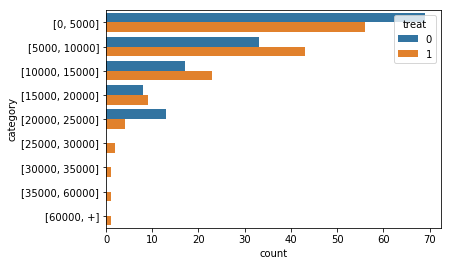

In [21]:
plot_distribution(matched_df, 're78', EARNINGS_STEP)

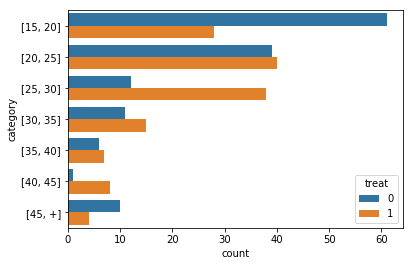

In [22]:
plot_distribution(matched_df, 'age', AGE_STEP)

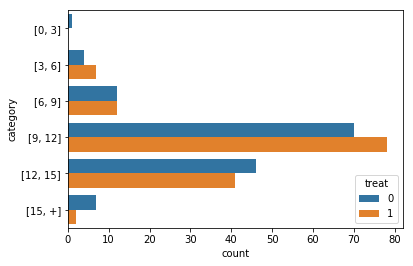

In [23]:
plot_distribution(matched_df, 'educ', EDUC_STEP)

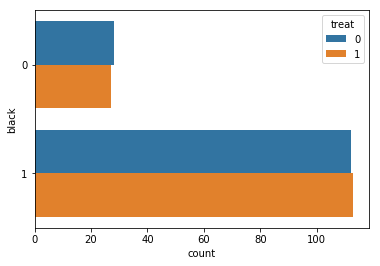

In [24]:
plot_distribution_binary(matched_df, 'black')

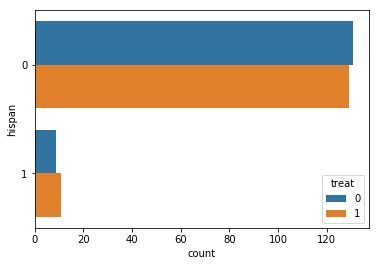

In [25]:
plot_distribution_binary(matched_df, 'hispan')

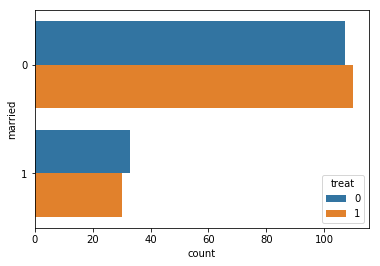

In [26]:
plot_distribution_binary(matched_df, 'married')

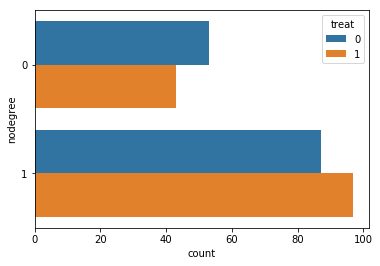

In [27]:
plot_distribution_binary(matched_df, 'nodegree')

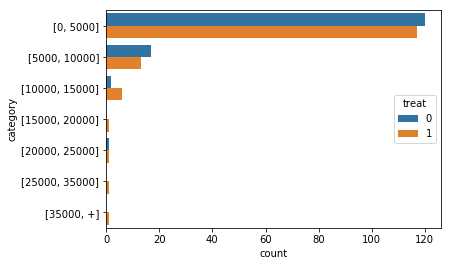

In [28]:
plot_distribution(matched_df, 're74', EARNINGS_STEP)

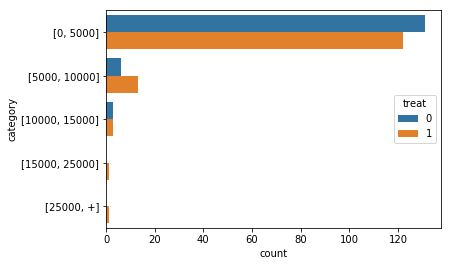

In [30]:
plot_distribution(matched_df, 're75', EARNINGS_STEP)

In [31]:
matched_df.shape

(280, 12)

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


The 'black' feature is still unbalanced.

In [ ]:
print(clean_df[clean_df.treat==1].black.sum(),
      clean_df[clean_df.treat==0].black.sum(),
clean_df[clean_df.treat==1].shape[0] - clean_df[clean_df.treat==1].black.sum(),
clean_df[clean_df.treat==0].shape[0] - clean_df[clean_df.treat==0].black.sum())

In [ ]:
black_we_want = clean_df.index[(clean_df.treat == 1) & (clean_df.black == 1)][:52]
balanced_clean_df = clean_df.drop(black_we_want)
print(balanced_clean_df.shape,clean2_df.shape)
balanced_clean_df[balanced_clean_df.treat==1].black.sum()

In [ ]:
for i in tqdm(range(1)):
    non_t_size, t_size = balanced_clean_df.treat.value_counts().values

    c = []
    for i, score_1 in enumerate(balanced_clean_df.loc[balanced_clean_df['treat'] == 1, 'prop_score'].values):
        for j, score_0 in enumerate(balanced_clean_df.loc[balanced_clean_df['treat'] == 0, 'prop_score'].values):
            c.append(1000 if balanced_clean_df[balanced_clean_df['treat'] == 1]['black'].values[i] != balanced_clean_df[balanced_clean_df['treat'] == 0]['black'].values[j] else np.abs(score_1 - score_0))

    b = []
    A1 = []
    for i in range(t_size):
        tab = []
        for j in range(len(c)):
            if j >= i * non_t_size and j < (i + 1) * non_t_size:
                tab.append(-1)
            else:
                tab.append(0)
        A1.append(tab)
        b.append(-1)

    A2 = []
    for i in range(non_t_size):
        tab = []
        for j in range(len(c)):
            if (j - i) % non_t_size == 0:
                tab.append(1)
            else:
                tab.append(0)
        A2.append(tab)
        b.append(1)

A = A1 + A2

In [ ]:
n_res = solve_linprog(c, A, b)

In [ ]:
resu = n_res.x.reshape(t_size,non_t_size)
print(resu.shape)
indices = np.argmax(resu,axis=1)
treated_df = balanced_clean_df[balanced_clean_df['treat']==1]
non_treated_df = balanced_clean_df[balanced_clean_df['treat'] == 0].iloc[indices]
matched_df = pd.concat([treated_df, non_treated_df])

In [ ]:
plot_distribution_binary(matched_df, 'black')

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


In [ ]:
m_nt = np.mean(non_treated_df['re78'])
m_t = np.mean(treated_df['re78'])
m_nt,m_t

In [ ]:
plot_distribution(matched_df, 're78', EARNINGS_STEP)

# Question 2

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequency–inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

## Solution

### Explanation and assumptions

#### Explanation

#### Assumptions

### Data retrieving

We directly load the data using sklearn

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train')

In [ ]:
newsgroups_test = fetch_20newsgroups(subset='test')

And we convert the text to vectors taking care of setting a *max_features* parameter in order to have the same number of features in the train and test set.

In [ ]:
vectorizer = TfidfVectorizer()
X_test = vectorizer.fit_transform(newsgroups_test.data)
print('Test set shape:', X_test.shape)
max_features = X_test.shape[1]

In [ ]:
vectorizer = TfidfVectorizer(max_features=max_features)
X_train = vectorizer.fit_transform(newsgroups_train.data)
print('Training set shape:', X_train.shape)

### Random forest

In [ ]:
SCORING = ['accuracy', 'neg_mean_squared_error']

In [ ]:
def runCV(clf, X_train, y_train, k):
    scores = cross_validate(clf, X_train, y_train, cv=k, scoring=SCORING, return_train_score=False)
    print_scores(scores)
    return scores
        
def print_scores(scores):
    print('Scores')
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print("RMSE: %0.2f (+/- %0.2f)" % (np.sqrt(-scores['test_neg_mean_squared_error']).mean(), scores['test_neg_mean_squared_error'].std() * 2))

With **k-fold cross validation** and **grid_search**, we found that good parameters are:

* n_estimators = 350
* max_depth = 80

Further fine-tuning can be done but we estimated that those parameters were enough considering the long running-time involved in finding the best parameters.

In [ ]:
def fine_tuning(depths, estimators):
    best_depth = 0;
    best_estimators = 0;
    best_acc = 0;

    for max_depth in depths:
        for n_estimators in estimators:
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                random_state=42,
                n_jobs=-1
            )
            scores = runCV(clf, X_train, newsgroups_train.target, 7)
            acc = scores['test_accuracy'].mean()

            if acc > best_acc:
                best_depth = max_depth
                best_estimators = n_estimators
                best_acc = acc
                
    print('Best parameters are (accuracy of', best_acc, '):')
    print('Depth:', best_depth, 'n_estimators:', best_estimators)
    
    return best_depth, best_etimators

In [ ]:
fine_tuning([75, 80, 85], [350, 400])

In [ ]:
max_depth = 80
n_estimators = 350

In [ ]:
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1)
clf.fit(X_train, newsgroups_train.target)

### Model assessment

In [ ]:
#acc = accuracy_score(newsgroups_test.target, clf.predict(X_test))
clf.predict(X_test)
#print('Accuracy:', acc * 100)